# CCAMLR Community Detection

We will try to detect the coalitions and investigate the probability that they are just random chance using a number of community detection methods.

Next, we will try to identify brokers in CCAMLR. 

# Read the Data

Get the data from the Excel file. lower_year_threshold and upper_year_threshold track the network between two given years.

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
from networkx import stochastic_block_model
import community as community_louvain
from sklearn.cluster import KMeans
from pygsp import graphs
from sklearn.cluster import SpectralClustering  # Use spectral clustering
from sklearn.metrics.cluster import normalized_mutual_info_score
import random

from sklearn.metrics.cluster import normalized_mutual_info_score

lower_year_threshold = 1980  # Define your lower year threshold
upper_year_threshold = 2023  # Define your upper year threshold

# Read the CCAMLR dataset and initialise it into a Pandas Dataframe
def read_CCAMLR_dataset():
    # Define the path to the Excel file
    file_path = 'CCAMLR.xlsx'

    # Read the Excel file into a DataFrame
    df = pd.read_excel(file_path,sheet_name='WP only')
    df['Year'] = df['Year'].astype(int)

    # Display the DataFrame
    return df

# Df is the returned pandas dataframe.
df = read_CCAMLR_dataset()
print(df)


               Reference                                           Document  \
0                     R1                         Proposal to amend CM 10-02   
1                     R2                      Proposal to amend CM 10-09 r1   
2    CCAMLR-41/25 Rev. 1  Amendments to CCAMLR Conservation Measures 21‐...   
3    CCAMLR-41/26 Rev. 1       Proposal to amend Conservation Measure 26-01   
4           CCAMLR-41/27  Draft conservation measure for an East Antarct...   
..                   ...                                                ...   
404   CCAMLR-I/24 Rev. 1           Amendment to Draft Financial Regulations   
405          CCAMLR-I/26  Proposed Amendments to the Draft Headquarters ...   
406          CCAMLR-I/30  Amendments to the Draft Headquarters Agreement...   
407          CCAMLR-I/36  Draft Interim Agreement between the Government...   
408    CCAMLR-I/9 Rev. 1              Draft Budget Estimates, 1982 and 1983   

     Year                          Topic Paper_type

# Initialise the Network- Step 1
Initialise the node names of the various countries. <br>

NODES:  ['Technical Working Group', 'Argentina', 'CDS', 'New Zealand', 'Uruguay', 'Secretariat', 'Norway', 'Brazil', 'South Africa', 'Belgium', 'Poland', 'Korea (ROK)', 'India', 'China', 'Japan', 'Germany', 'Namibia', 'United Kingdom', 'Australia', 'France', 'Russian Federation', 'Ukraine', 'Spain', 'VMS', 'Chile', 'Sweden', 'EU', 'EEC', 'DOCEP', 'United States', 'Italy']
31


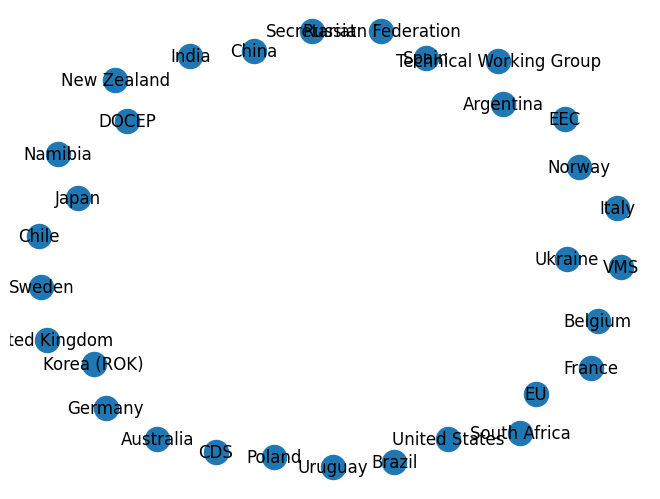

In [2]:
# Find all the nodes in the graph. 
def get_nodes(df):
    # Go through each cell of the dataframe and look for unique authors to set as nodes.
    author_columns = [f'Author {i}' for i in range(1, 11)]
    nodes=set()
    # For each cell in the section that we need to look through
    for col in author_columns:
        for row in filtered_df.index:
            author = filtered_df.at[row, col]
            # If the row is not blank
            if pd.notna(author):
                # Add the author in if we don't have it. 
                if author not in nodes:
                    nodes.add(author)
    nodes=list(nodes)
    return nodes

filtered_df = df[(df['Year'] <= upper_year_threshold) & (df['Year'] >= lower_year_threshold)]
# Get the nodes using the function above.
nodes = get_nodes(df)
print("NODES: " , nodes)
print(len(nodes))

# Initialize the network in networkx
CCAMLR_network = nx.Graph()

# Add nodes to the graph
CCAMLR_network.add_nodes_from(nodes)

# Draw the network
nx.draw(CCAMLR_network, with_labels=True)
plt.show()


# Initialise the Network- Step 2
Create the graph with an edge between nodes $a$ and $b$ if they share at least one working paper. <br>
The weight of this edge is given by the number of working papers that $a$ and $b$ have collaborated on in the dataset. <br>

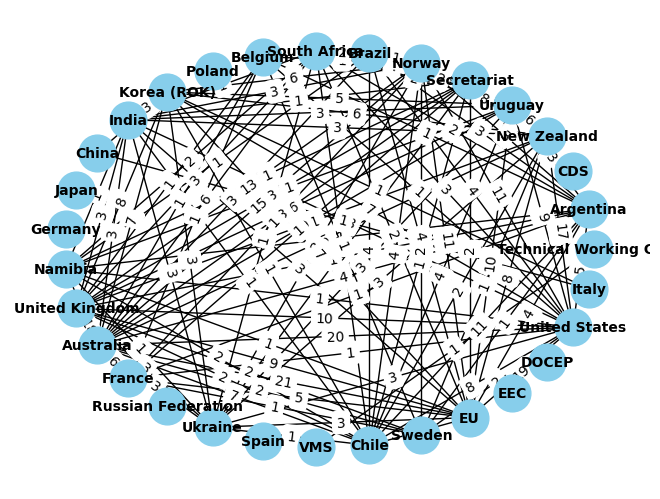

In [3]:
# Adds edges based on occurrences in the same row. 
def add_edges(df,CCAMLR_network):
    nodes=list(CCAMLR_network.nodes)
    # Each working paper with all the authors in that paper. 
    author_columns = [f'Author {i}' for i in range(1, 11)]
    all_rows = df[author_columns].values.tolist()
    # For each pair of nodes
    for n1 in nodes:
        for n2 in nodes:
            #Count the number of working papers that node n1 and node n2 share
            if n1!=n2:
                count=0
                for r in all_rows:
                    if n1 in r and n2 in r:
                        count+=1
                        continue
                # Count is the total weight of the edge. 
                if count >=1:
                    CCAMLR_network.add_edge(n1,n2,weight=count)
    return

add_edges(filtered_df,CCAMLR_network)

# Test the edge collection, to see if it is correct. 
#Checked and looks good!
# e.g correctly reports that Australia and Norway share 15 working papers together.
#print(CCAMLR_network["Australia"]["Norway"]["weight"])

# Visualize the network
pos = nx.circular_layout(CCAMLR_network)  # Positions for all nodes with specified spacing
nx.draw(CCAMLR_network, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_weight='bold')

# Draw edge labels
edge_labels = nx.get_edge_attributes(CCAMLR_network, 'weight')
nx.draw_networkx_edge_labels(CCAMLR_network, pos, edge_labels=edge_labels)

plt.show()

# Detect Coalitions:

Use Stochastic Block Models to define communities.

/Users/nandini_sydney/Library/Python/3.10/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Detected Communities:
Community 1: ['Technical Working Group', 'VMS']
Community 0: ['Argentina', 'Secretariat', 'Brazil', 'South Africa', 'Namibia', 'Chile']
Community 3: ['CDS', 'New Zealand', 'Uruguay', 'Norway', 'Belgium', 'Poland', 'Korea (ROK)', 'India', 'Japan', 'Germany', 'United Kingdom', 'Australia', 'France', 'Russian Federation', 'Ukraine', 'Spain', 'Sweden', 'EU', 'EEC', 'DOCEP', 'United States']
Community 2: ['China', 'Italy']


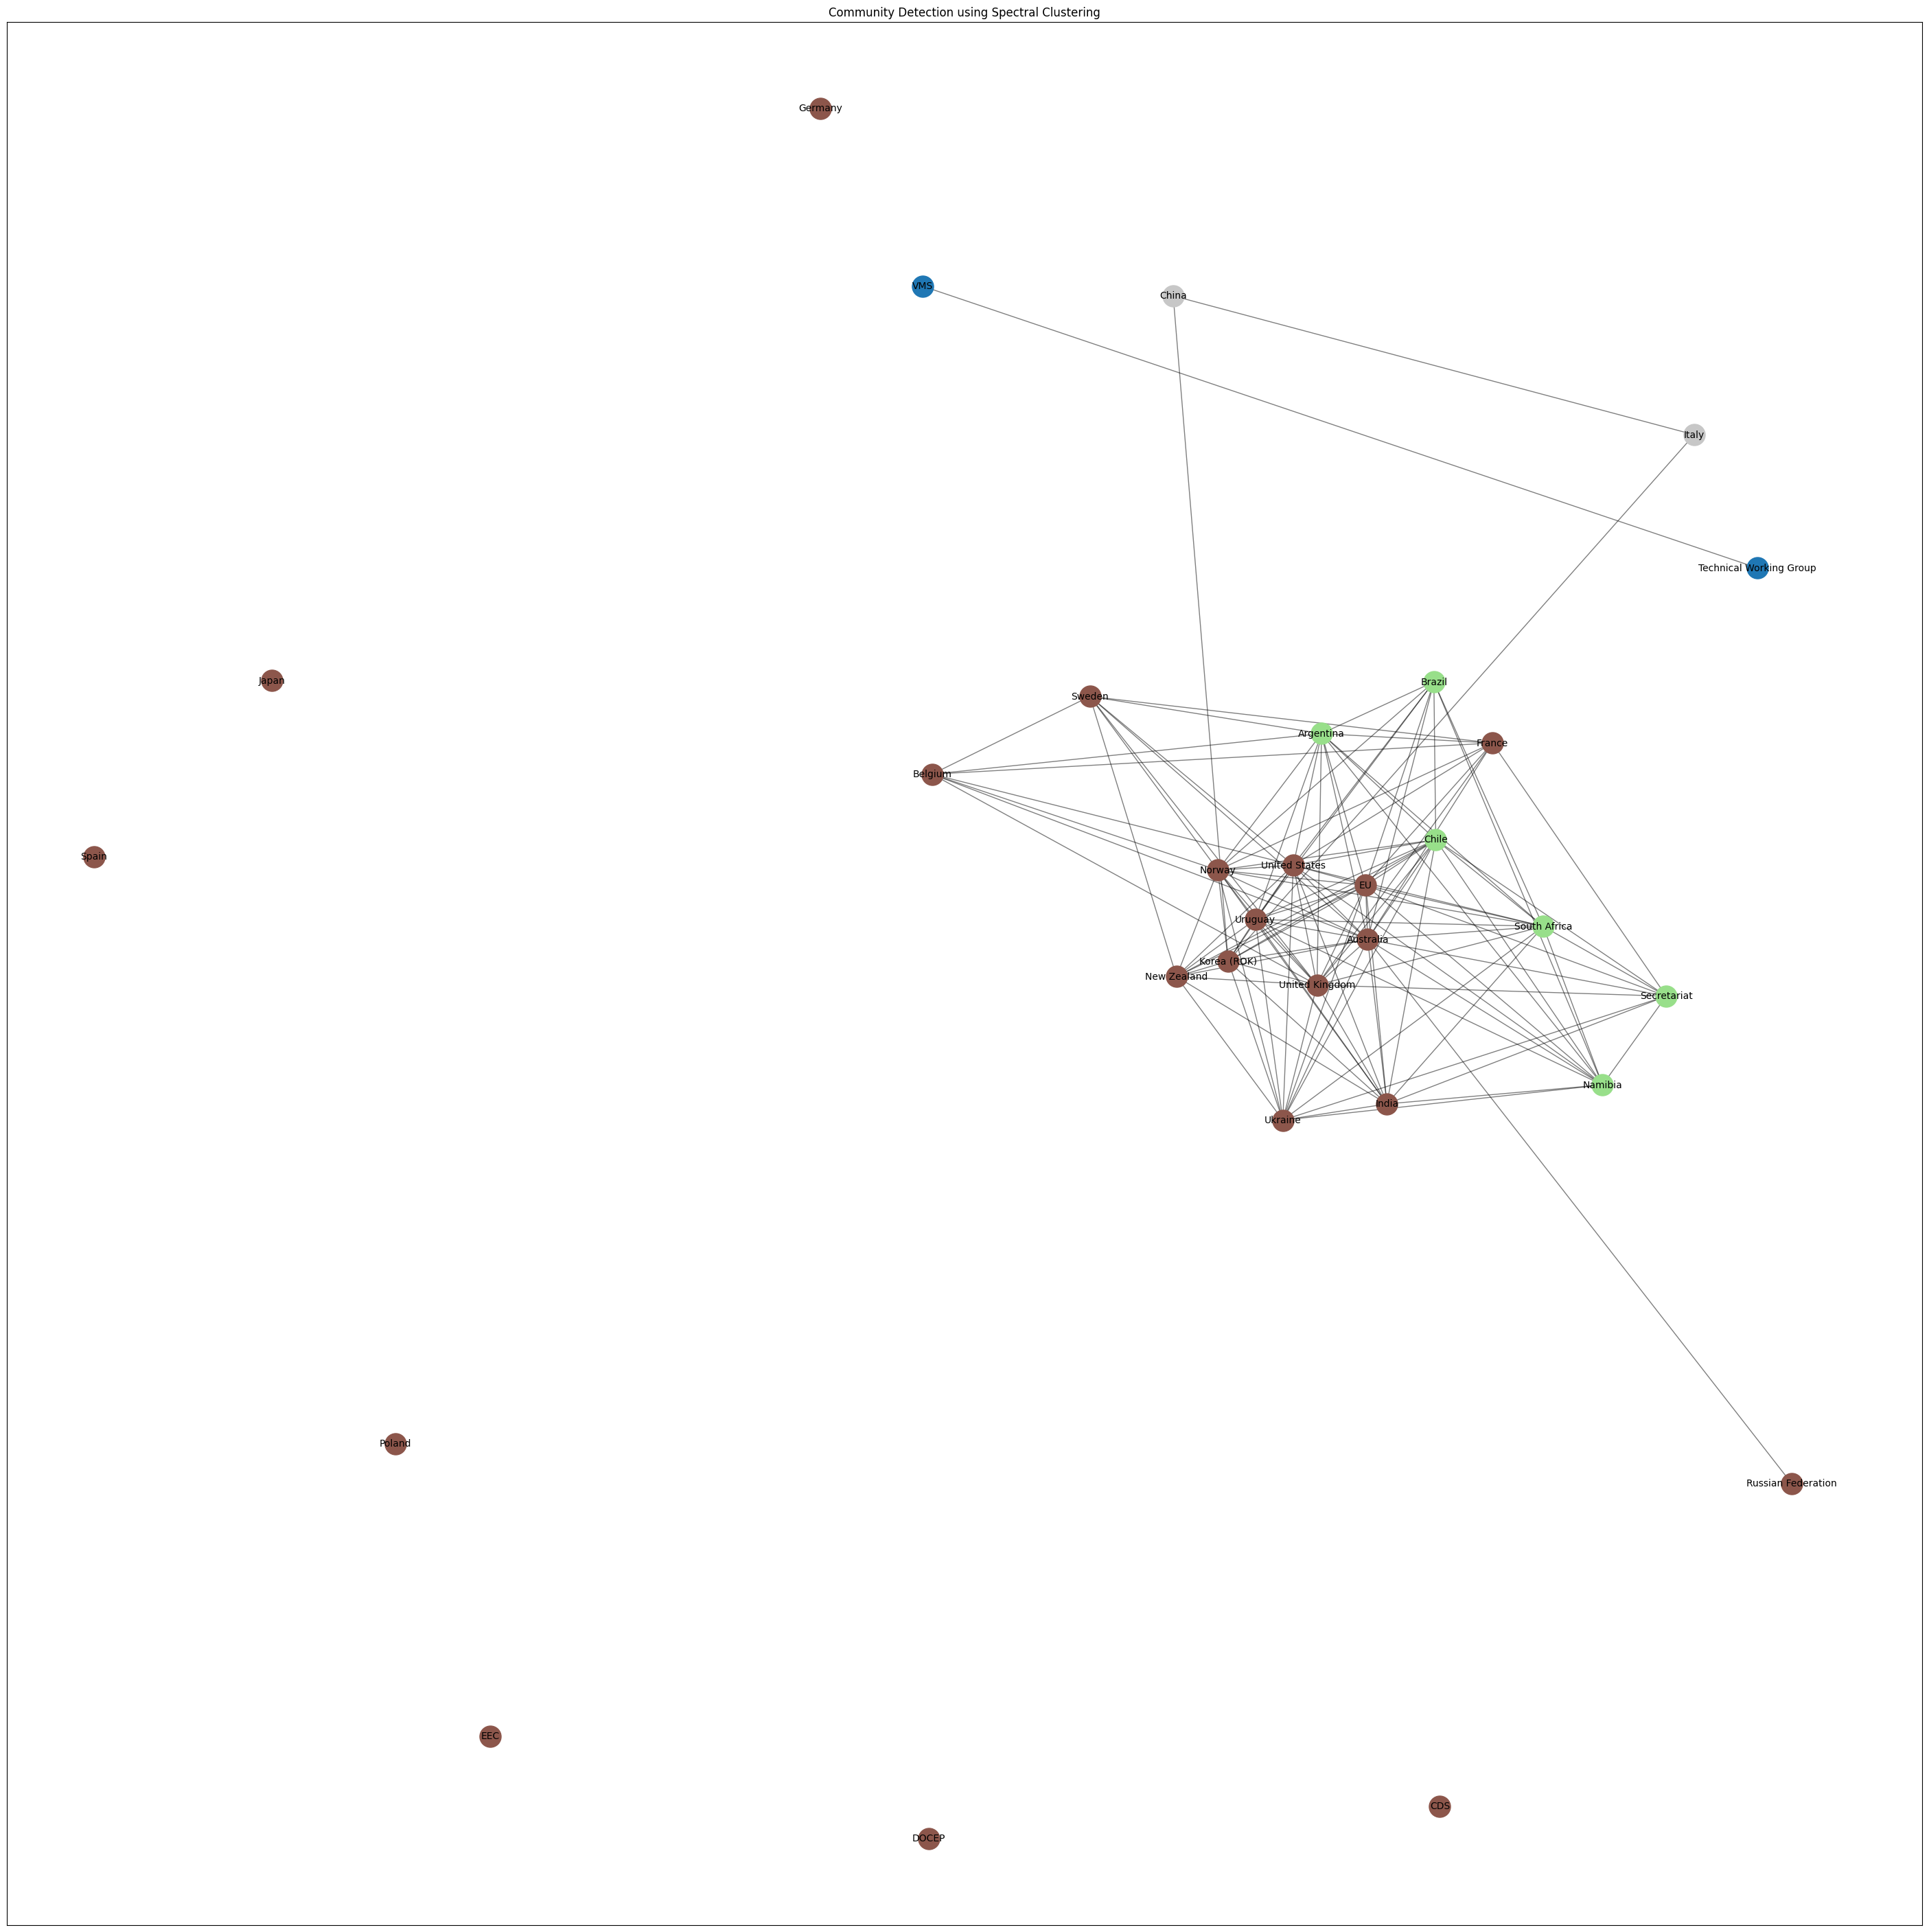

"\ndef find_edge_weight(network, node1, node2):\n    #Find the weight of the edge between two nodes in the network.\n    if network.has_edge(node1, node2):\n        weight = network[node1][node2]['weight']\n        return weight\n    else:\n        return None\n\n\nnode1 = 'Sweden'\nnode2 = 'Argentina'\nweight = find_edge_weight(CCAMLR_network, node1, node2)\nprint(weight)\n"

In [4]:
"""
#Louvain method
# Community detection using the Louvain method
partition = community_louvain.best_partition(CCAMLR_network)

# Group nodes by their communities
communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = []
    communities[community_id].append(node)

print("Detected Communities:")
for community_id, members in communities.items():
    print(f"Community {community_id}: {members}")

# Visualize the network with communities
pos = nx.spring_layout(CCAMLR_network)
colors = [plt.cm.tab20(i / len(communities)) for i in range(len(communities))]

for i, (community_id, members) in enumerate(communities.items()):
    nx.draw_networkx_nodes(CCAMLR_network, pos, nodelist=members, node_color=[colors[i]])
nx.draw_networkx_edges(CCAMLR_network, pos, alpha=0.5)
nx.draw_networkx_labels(CCAMLR_network, pos)

plt.show()
"""



# Convert the network to an adjacency matrix
adj_matrix = nx.to_numpy_array(CCAMLR_network)

# Fit SBM using Spectral Clustering as an approximation
# Choose the number of communities (you can tweak this number)
n_communities = 4  # Adjust based on your data



sc = SpectralClustering(n_clusters=n_communities, affinity='precomputed', random_state=42)
labels = sc.fit_predict(adj_matrix)

"""

# Create a DataFrame for node and community labels
node_community_df = pd.DataFrame({
    'Node': nodes,
    'Community': labels
})

# Sort nodes by their community labels
sorted_nodes = node_community_df.sort_values('Community')['Node'].tolist()

# Create a mapping from node to index
node_index_map = {node: idx for idx, node in enumerate(sorted_nodes)}

# Reorder adjacency matrix
reordered_adj_matrix = np.zeros_like(adj_matrix)

for i, node1 in enumerate(sorted_nodes):
    for j, node2 in enumerate(sorted_nodes):
        reordered_adj_matrix[i, j] = adj_matrix[node_index_map[node1], node_index_map[node2]]

# Visualize reordered adjacency matrix
plt.figure(figsize=(10, 8))
plt.imshow(reordered_adj_matrix, cmap='viridis', interpolation='none')
plt.colorbar()

# Add labels to the axes
plt.xticks(ticks=np.arange(len(sorted_nodes)), labels=sorted_nodes, rotation=90, fontsize=8)
plt.yticks(ticks=np.arange(len(sorted_nodes)), labels=sorted_nodes, fontsize=8)

plt.title('Reordered Adjacency Matrix')
plt.show()
"""


# Group nodes by their community label
communities = {}
for i, label in enumerate(labels):
    if label not in communities:
        communities[label] = []
    communities[label].append(nodes[i])

print("Detected Communities:")
for community_id, members in communities.items():
    print(f"Community {community_id}: {members}")

# Visualize the network with improved layout and sizing
plt.figure(figsize=(36, 36))  # Increase figure size

# Use spring_layout with a larger k value to spread the nodes out
pos = nx.spring_layout(CCAMLR_network, k=0.9, iterations=50)

colors = [plt.cm.tab20(i / n_communities) for i in range(n_communities)]

for i, (community_id, members) in enumerate(communities.items()):
    nx.draw_networkx_nodes(CCAMLR_network, pos, nodelist=members, node_color=[colors[i]], node_size=500)

nx.draw_networkx_edges(CCAMLR_network, pos, alpha=0.5)
nx.draw_networkx_labels(CCAMLR_network, pos, font_size=10, font_color="black")

plt.title("Community Detection using Spectral Clustering")
plt.show()


"""
def find_edge_weight(network, node1, node2):
    #Find the weight of the edge between two nodes in the network.
    if network.has_edge(node1, node2):
        weight = network[node1][node2]['weight']
        return weight
    else:
        return None


node1 = 'Sweden'
node2 = 'Argentina'
weight = find_edge_weight(CCAMLR_network, node1, node2)
print(weight)
"""

# Evaluate the Stability of the Community

In [5]:
def extract_largest_component(G):
    """Extract the largest connected component from the network."""
    largest_cc = max(nx.connected_components(G), key=len)
    G_largest = G.subgraph(largest_cc).copy()
    return G_largest

def perturb_network(G, edge_removal_fraction=0.05, edge_addition_fraction=0.05):
    """Perturbs the network by removing and adding edges."""
    G_perturbed = G.copy()
    
    # Edge removal
    edges = list(G_perturbed.edges())
    num_remove = int(edge_removal_fraction * len(edges))
    remove_edges = random.sample(edges, num_remove)
    G_perturbed.remove_edges_from(remove_edges)
    
    # Edge addition (only possible between unconnected nodes)
    non_edges = list(nx.non_edges(G_perturbed))
    num_add = int(edge_addition_fraction * len(non_edges))
    add_edges = random.sample(non_edges, num_add)
    G_perturbed.add_edges_from(add_edges)
    
    return G_perturbed

def run_community_detection(G, n_communities):
    """Runs Spectral Clustering to detect communities."""
    adj_matrix = nx.to_numpy_array(G)
    sc = SpectralClustering(n_clusters=n_communities, affinity='precomputed', random_state=42)
    labels = sc.fit_predict(adj_matrix)
    return labels

def permutation_test_nmi(original_labels, perturbed_labels, num_permutations=1000):
    """Performs a permutation test to compute a p-value for the NMI score."""
    observed_nmi = normalized_mutual_info_score(original_labels, perturbed_labels)
    
    permuted_nmis = []
    for _ in range(num_permutations):
        permuted_labels = np.random.permutation(perturbed_labels)
        permuted_nmi = normalized_mutual_info_score(original_labels, permuted_labels)
        permuted_nmis.append(permuted_nmi)
    
    permuted_nmis = np.array(permuted_nmis)
    p_value = (np.sum(permuted_nmis >= observed_nmi) + 1) / (num_permutations + 1)
    
    return observed_nmi, p_value

def evaluate_stability_with_p_value(G, original_labels, n_communities, perturbations=10, edge_removal_fraction=0.05, edge_addition_fraction=0.05, num_permutations=1000):
    """Evaluates the stability of communities by perturbing the network and calculating a p-value for the NMI."""
    stability_scores = []
    p_values = []
    
    for _ in range(perturbations):
        # Perturb the network
        G_perturbed = perturb_network(G, edge_removal_fraction, edge_addition_fraction)
        
        # Run community detection on the perturbed network
        perturbed_labels = run_community_detection(G_perturbed, n_communities)
        
        # Evaluate stability using NMI and compute p-value
        observed_nmi, p_value = permutation_test_nmi(original_labels, perturbed_labels, num_permutations=num_permutations)
        stability_scores.append(observed_nmi)
        p_values.append(p_value)
    
    avg_stability = sum(stability_scores) / len(stability_scores)
    avg_p_value = sum(p_values) / len(p_values)
    
    return avg_stability, avg_p_value

# Example usage:
n_communities=7

# 1. Extract the largest connected component
G_largest = extract_largest_component(CCAMLR_network)

# 2. Run community detection on the largest component
original_labels = run_community_detection(G_largest, n_communities)

# 3. Evaluate the stability on the largest component
avg_stability, avg_p_value = evaluate_stability_with_p_value(G_largest, original_labels, n_communities, perturbations=100)

print(f"Average Stability Score (NMI): {avg_stability:.4f}")
print(f"Average p-value: {avg_p_value:.4f}")


# Are the amounts of modularity--> Go to authorship list. 
# Back to the list of WPs and authors
# Calculate frequency distribution of authors. e.g UK 18% of WPs.
# Back to the list of WPs- replace the actual authors with a random selection from that probability vector. 
# Do we get communities? 
# 100 other realisations. 
# How long are the authorship lists?
# Modularity is that metric. How many of them are bigger than the one that we actually observe?

/Users/nandini_sydney/Library/Python/3.10/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Average Stability Score (NMI): 0.8936
Average p-value: 0.0010
